# Market Making with Reinforcement Learning

In [1]:
# Data Handling
import pandas as pd
import numpy as np

# Generic
from collections import defaultdict
from tqdm.auto import tqdm

# Data Visualization
import matplotlib.pyplot as plt 

# Reinforcement Learning
import gym

# Custom Modules
from Environment.market_making import MarketMakerEnv, PhiTransform
from data.data_gen import DataGenerator
from algorithms import TileCodingQLearningAgent

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Set the seed for reproducibility
SEED = 42
np.random.seed(SEED)

## Setup the training environment

In [2]:
lob_data = DataGenerator._generator('data/lob.csv', levels=1)
lob_data = lob_data.head(1200).values

In [3]:
# Create the environment
env = MarketMakerEnv(
    lob_data=lob_data,
    horizon=1000,
    phi_transorm=PhiTransform.PnL_asymm_dampened,
)
initial_state = env.reset()
display(initial_state)

array([ 2.23990000e+02,  1.00000000e+02,  2.23750000e+02,  7.40000000e+01,
        2.23870000e+02,  2.40000000e-01, -5.00000000e-03, -1.49425287e-01,
       -2.60000000e+01, -2.23338917e-05,  2.40100065e-05,  4.16666667e+01])

In [4]:
# Define the agent
agent = TileCodingQLearningAgent(
    env=env,
    alpha=1e-3,
    gamma=0.99,
    epsilon=0.1,
    epsilon_decay=0.995,
    epsilon_min=1e-2,
)

# Train the agent
agent.train(n_episodes=50)

Training:   0%|          | 0/50 [00:00<?, ?episode/s]

In [7]:
# Test the agent
rewards = agent.test(n_episodes=30)

Testing:   0%|          | 0/30 [00:00<?, ?episode/s]

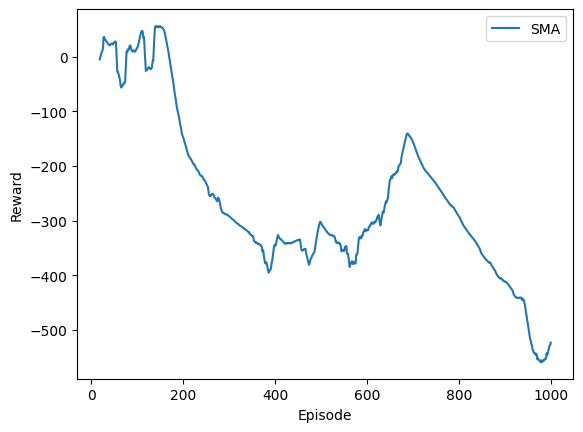

In [11]:
# Smooth the rewards
sma_window = 20
rewards_sma = pd.Series(rewards).rolling(window=sma_window).mean()

# Plot the rewards
# plt.plot(rewards, label='Reward')
plt.plot(rewards_sma, label='SMA')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.show()